# Representación de palabras mediante espacios vectoriales

## Créditos

Este material está fuertemente inspirado en los cursos de Stanford [CS224n: Natural Language Processing with Deep Learning](http://web.stanford.edu/class/cs224n/) y [CS224u: Natural Language Understanding](http://web.stanford.edu/class/cs224u/), así también como del [blog de Jay Alammar](http://jalammar.github.io/).

In [1]:
__author__ = "Cristian Cardellino"

## Contenidos

1. [Representación de palabras](#Representación-de-palabras)
1. [Representación distribuída de palabras](#Representación-distribuída-de-palabras)
1. [Diseño de matrices](#Diseño-de-matrices)
1. [Comparación de vectores](#Comparación-de-vectores)
1. [Métodos de reponderación](#Métodos-de-reponderación)
1. [Reducción de dimensionalidad](#Reducción-de-dimensionalidad)
1. [Word Embeddings](#Word-Embeddings)
1. [Word2vec](#Word2vec)
1. [Información de subpalabras](#Información-de-subpalabras)
1. [Visualización](#Visualización)

In [2]:
%matplotlib inline

import numpy as np
import os
import pandas as pd
import vsm

from gensim.models import KeyedVectors

## Representación de palabras

1. [Características de las palabras](#Características-de-las-palabras)
1. [Representación mediante taxonomías](#Representación-mediante-taxonomías)
1. [Representación discreta](#Representación-discreta)
1. [Ejemplo de representación discreta](#Ejemplo-de-representación-discreta)

### Características de las palabras

- Son la **unidad básica** en cualquier tarea de procesamiento de lenguaje natural (PLN).
- Cualquier modelo de PLN requiere como entrada la **representación de una palabra**.
- Gran parte del trabajo de PLN solía representar las palabras como **símbolos atómicos**.
- Las nociones de **similitu y distancia** entre palabras son cruciales para tareas de PLN.

### Representación mediante taxonomías

- El **sentido** de una palabras es la idea que una palabra (o frase) representa.
- Se puede representar mediante recursos del estilo de las **taxonomías**.
- Ofrecen **información rica y estructurada**.
    - WordNet asigna relaciones de **hiperonimia/hiponimia** (relación *es-un*), y **sinonimia**.
    - FrameNet establece la **estructura** mediante un marco sintáctico y semántico de las palabras.
- Son **difíciles y caros de obtener y actualizar** (requiren anotación humana).

In [3]:
from nltk.corpus import wordnet as wn  # Run nltk.download("wordnet") first

dog = wn.synset("dog.n.01")

print("Dog's hypernyms:")
for hypernym in dog.hypernyms():
    print(hypernym)

Dog's hypernyms:
Synset('canine.n.02')
Synset('domestic_animal.n.01')


### Representación discreta

- Para aplicar medidas de similitud y distancia (e.g. euclídea, coseno), utilizamos **vectores que representen palabras**.
- Primera aproximación: **vectores *one-hot***.
- Para cada palabra del vocabulario, tenemos un vector.
- En términos de espacio vectorial, el vector tiene un **1** en una de sus dimensiones y __0s__ en todas las demás.
- **Dimensionalidad muy alta** (el inglés tiene un estimado de 13 millones de palabras).
- Los vectores son **ralos** (o esparsos), tienen muchos ceros.

### Ejemplo de representación discreta

Dado un corpus:

- "El fallo fue decisivo"
- "La corte rectificará el fallo"

Tenemos un vocabulario $V = \{corte, decisivo, el, fallo, fue, la, rectificará\}$.

Codificamos un número $|V| = 7$ de vectores para cada palabra $w^{(i)} \in \mathbb{R}^{|V|}$.

### Ejemplo de representación discreta

$$
    w^{corte} =
    \begin{bmatrix}
       1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0
    \end{bmatrix} ,
    w^{decisivo} =
    \begin{bmatrix}
       0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0
    \end{bmatrix} ,
    w^{el} =
    \begin{bmatrix}
       0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0 \\ 0
    \end{bmatrix} ,
    w^{fallo} =
    \begin{bmatrix}
       0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0 \\ 0
    \end{bmatrix} ,
$$

$$
    w^{fue} =
    \begin{bmatrix}
       0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0 \\ 0
    \end{bmatrix}
    w^{la} =
    \begin{bmatrix}
       0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1 \\ 0
    \end{bmatrix} ,
    w^{rectificará} =
    \begin{bmatrix}
       0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 1
    \end{bmatrix}
$$

In [4]:
corpus = [
    "El fallo fue decisivo", 
    "La corte rectificará el fallo"
]

tokenized_corpus = [
    [word.lower() for word in doc.split()] for doc in corpus
]

vocabulary = sorted(set([
    word for doc in tokenized_corpus for word in doc
]))

one_hot_vectors = np.eye(len(vocabulary), dtype=np.int)

for doc in tokenized_corpus:
    print(np.array([
        one_hot_vectors[vocabulary.index(word), :] for word in doc
    ]))

[[0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0]]
[[0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]]


/tmp/ipykernel_2201310/4004610901.py:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  one_hot_vectors = np.eye(len(vocabulary), dtype=np.int)


## Representación distribuída de palabras

1. [Concepto](#Concepto)
1. [Motivación](#Motivación)
1. [Hipótesis para guiarse](#Hipótesis-para-guiarse)

### Concepto

- Idea: Representar una palabra **mediante sus vecinos**.
    - Es una de las **ideas más importantes** en PLN moderno.

#### Ejemplo: 

- "_El gobierno rescató a los_ **bancos** _ante la crisis de crédito_".
- "_La municipalidad reparará los_ **bancos** _de la plaza_".

En estos ejemplos, las palabras que están en _cursiva_ representarán las palabras en **negrita**.

### Motivación

- La representación distribuída nos da pie a pensar como los vectores **codifican el significado de las unidades linguísticas** (palabras, oraciones, documentos, etc.).
- Son la base de los **modelos de espacio vectorial**.
- Piezas fundamentales en modelos para **Procesamiento y Comprensión de Lenguaje Natural**.
- Estas representaciones pueden ser usadas, entre otros, para:
    - Entender y modelar fenómenos sociales y lingüísticos.
    - Entrada para modelos de aprendizaje automático.

### Hipótesis para guiarse

- "You shall know a word by the company it keeps" (Firth, 1957).
- "The complete meaning of a word is always contextual, and no study of meaning apart from context can be taken seriously" (Firth, 1957).
- "The meaning of a word is its use in the language" (Wittgenstein, 1957).
- "Distributional statements can cover all of the material of a language without requiring support from other types of information" (Harris, 1954)
- "If units of text have similar vectors in a text frequency matrix, then they tend to have similar meanings." (Turney & Pantel, 2010)

## Diseño de matrices

1. [Objetivos del diseño de matrices](#Objetivos-del-diseño-de-matrices)
1. [Matriz de co-ocurrencia de palabras](#Matriz-de-co-ocurrencia-de-palabras)
1. [Matriz de documentos](#Matriz-de-documentos)
1. [Ventana y ponderación](#Ventana-y-ponderación)
1. [Más diseños de matrices](#Más-diseños-de-matrices)
1. [Consideraciones](#Consideraciones)

### Objetivos del diseño de matrices

- Buscamos representar palabras de manera matemática.
    - Idea: Mediante una matriz (vista como un conjunto de vectores)
- Hay que definir la construcción de una matriz.
    - Muchas opciones de diseño.
    - Distinto impacto tendrán las decisiones tomadas respecto al modelado del texto.

### Matriz de co-ocurrencia de palabras

- Cada palabra se representa por las palabras a su alrededor (dada una ventana).
- La matriz es simétrica (independiente de la posición de las palabras).
    - Esto se conoce como "bolsa de palabras" (o _bag of words_)
- Dado un vocabulario $V$:
    - Matriz de co-ocurrencias $X \in \mathbb{R}^{|V|\times|V|}$
    - $X_{ij}$ representa la co-ocurrencia entre la palabras $w^{(i)}$ y $w^{(j)}$

### Matriz de co-ocurrencia de palabras

<img src="img/word-word-matrix.png" width="90%"/>
<div style="text-align: right; font-size:.9em;">Source: <a href="http://web.stanford.edu/class/cs224u/" target="_blank">http://web.stanford.edu/class/cs224u/</a></div>

### Matriz de documentos

- Cada documento se representa por las palabras que lo conforman.
- Se usa un modelo de bolsa de palabras: no importa la posición.
- Dadas $N$ palabras en un corpus de $M$ documentos:
    - Matriz de documentos $X \in \mathbb{R}^{N \times M}$
    - $X_{ij}$ representa la ocurrencia de la palabra $w^{(i)}$ en el documento $d^{(j)}$.

### Matriz de documentos

<img src="img/term-document-matrix.png" width="90%"/>
<div style="text-align: right; font-size:.9em;">Source: <a href="http://web.stanford.edu/class/cs224u/" target="_blank">http://web.stanford.edu/class/cs224u/</a></div>

### Ventana y ponderación

- La ventana define la **cantidad de palabras en el contexto** a considerar.
- La ponderación (*scaling*) le da un **peso a la palabra** en la suma total.
    - Igual peso para todas las palabras, i.e. bolsa de palabras.
    - Peso distinto de acuerdo a la distancia, e.g. decaimiento fraccional.
    - Peso binario, i.e. la palabra está o no.

<img src="img/window-scaling.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="http://web.stanford.edu/class/cs224u/" target="_blank">http://web.stanford.edu/class/cs224u/</a></div>

### Ventana y ponderación

- Ventanas más grandes y con peso igual (_flat_) capturan **información semántica**.
    - Las matrices de documentos dan idea de la temática del documento.
- Ventanas más cortas y con pesos capturan **información sintáctica** (colocacional).
    - Las matrices de co-ocurrencias de palabras son de afinidad de palabras.
- El límite puede definirse más allá de una ventana fija.
    - Utilizar oraciones, párrafos o documentos tendrá consecuencias distintas.

In [5]:
infoleg5 = pd.read_csv("./data/infoleg_5window_scaled.csv.gz", index_col=0)

infoleg20 = pd.read_csv("./data/infoleg_20window_flat.csv.gz", index_col=0)

### Más diseños de matrices

- palabra $\times$ relación de dependencia
- palabra $\times$ contexto sintáctico
- adjetivo $\times$ sustantivo modificado
- palabra $\times$ consulta de búsqueda
- persona $\times$ producto
- palabra $\times$ persona
- verbo $\times$ sujeto $\times$ objeto
- ...

### Consideraciones

- Las matrices **incrementan con el vocabulario**.
    - Definir límites en vocabulario o bien lidiar con modelos muy grandes.
    - Por la ley de Zipf (Zipf, 1949), la lista de palabras con escasa aparición se vuelve muy grande.
- La elección de la ventana afecta en la obtención de **matrices más o menos dispersas**.
- Representar distintas unidades lingüísticas deriva en **más dispersión** (ver el ejemplo de word-word vs term-document).

## Comparación de vectores 

1. [Objetivos de comparar vectores](#Objetivos-de-comparar-vectores)
1. [Ejemplo de juguete](#Ejemplo-de-juguete)
1. [Distancia euclídea](#Distancia-euclídea)
1. [Normalización del vector](#Normalización-del-vector)
1. [Distancia coseno](#Distancia-coseno)
1. [Medidas basadas en coincidencias](#Medidas-basadas-en-coincidencias)
1. [Propiedades de una distancia](#Propiedades-de-una-distancia)
1. [Otras medidas](#Otras-medidas)
1. [Exploración de vecinos](#Exploración-de-vecinos)

### Objetivos de comparar vectores

- Está en el núcleo de nuestro análisis.
- Generalmente buscamos **medir distancias** entre vectores.
    - La idea es que palabras relacionadas estén cercanas en el espacio vectorial construído.
- El módulo [scipy.spatial.distance](http://docs.scipy.org/doc/scipy-0.14.0/reference/spatial.distance.html) ofrece una gran cantidad de métricas para comparar vectores.

### Ejemplo de juguete

<img src="img/vector-toy-example.png" width="75%" />
<div style="text-align: right; font-size:.9em;">Source: <a href="http://web.stanford.edu/class/cs224u/" target="_blank">http://web.stanford.edu/class/cs224u/</a></div>

### Ejemplo de juguete

In [6]:
ABC = pd.DataFrame([
    [ 2.0,  4.0], 
    [10.0, 15.0], 
    [14.0, 10.0]],
    index=['A', 'B', 'C'],
    columns=['dx', 'dy'])

ABC

,dx,dy
A,2.0,4.0
B,10.0,15.0
C,14.0,10.0


### Ejemplo de juguete

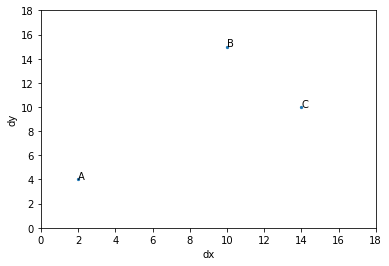

In [7]:
def plot_ABC(df):
    ax = df.plot.scatter(x='dx', y='dy', marker='.', legend=False)
    m = df.values.max(axis=None)
    ax.set_xlim([0, m*1.2])
    ax.set_ylim([0, m*1.2])
    for label, row in df.iterrows():
        ax.text(row['dx'], row['dy'], label)

plot_ABC(ABC)

### Distancia euclídea

- Es la **distancia** más básica e intuitiva entre dos vectores.
- La distancia euclídea entre dos vectores $u$ y $v$ de dimensión $n$ se define como:

$$\textbf{euclidean}(u, v) = \sqrt{\sum_{i=1}^{n}|u_{i} - v_{i}|^{2}}$$

- En dos dimensiones, se corresponde con la longitud de la línea más directa entre dos puntos.

<img src="img/euclidean-distance.png" width="75%" />
<div style="text-align: right; font-size:.9em;">Source: <a href="http://web.stanford.edu/class/cs224u/" target="_blank">http://web.stanford.edu/class/cs224u/</a></div>

### Distancia euclídea

In [8]:
def abc_comparisons(df, distfunc):
    for a, b in (('A', 'B'), ('B', 'C')):
        dist = distfunc(df.loc[a], df.loc[b])
        print(f"{distfunc.__name__}({a}, {b}) = {dist:7.02f}")

abc_comparisons(ABC, vsm.euclidean)

euclidean(A, B) =   13.60
euclidean(B, C) =    6.40


- Suponiendo que estos vectores fueran de palabras, hay algunos aspectos extraños:
    - Notar que las distribuciones de B y C son opuestas (e.g. "bueno" vs. "malo").
    - A y B están más alineadas en cambio, salvo por las frecuencias (e.g. "bueno" vs. "excelente").
- La distancia euclídea está **sesgada por tamaño**.

### Normalización del vector

- Buscamos quitar el sesgo. Para eso **normalizamos el vector de acuerdo a su longitud**.
- Definimos la **norma L2** de un vector:

$$\|u\|_{2} = \sqrt{\sum_{i=1}^{n} u_{i}^{2}}$$

- Luego, la normalización de $u$ se consigue dividiendo por su longitud (que es escalar):

$$\left[\frac{u_{1}}{\|u\|_{2}}, \frac{u_{2}}{\|u\|_{2}}, \ldots, \frac{u_{n}}{\|u\|_{2}}\right]$$

### Normalización del vector

<img src="img/length-normalization.png" width="75%" />
<div style="text-align: right; font-size:.9em;">Source: <a href="http://web.stanford.edu/class/cs224u/" target="_blank">http://web.stanford.edu/class/cs224u/</a></div>

### Normalización del vector

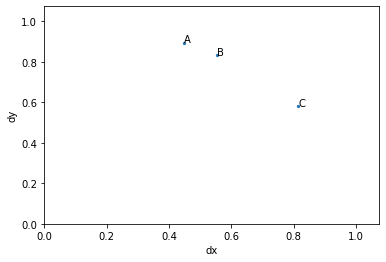

In [9]:
ABC_normed = ABC.apply(vsm.length_norm, axis=1)
plot_ABC(ABC_normed)

In [10]:
abc_comparisons(ABC_normed, vsm.euclidean)

euclidean(A, B) =    0.12
euclidean(B, C) =    0.36


### Distancia coseno

- La **distancia coseno toma toda la longitud en cuenta**.
- La distancia coseno entre dos vectores $u$ y $v$ de dimensión $n$ se define como:

$$\textbf{cosine}(u, v) = 1 - \frac{\sum_{i=1}^{n} u_{i} \cdot v_{i}}{\|u\|_{2} \cdot \|v\|_{2}}$$

- La similitud coseno (el término que se está restando), **mide el ángulo entre dos vectores**.
- Es **equivalente** a tomar la distancia euclídea de los vectores normalizados.

In [11]:
abc_comparisons(ABC, vsm.cosine)

cosine(A, B) =    0.01
cosine(B, C) =    0.07


### Distancia coseno

<img src="img/cosine-distance-1.png" width="75%" />
<div style="text-align: right; font-size:.9em;">Source: <a href="http://web.stanford.edu/class/cs224u/" target="_blank">http://web.stanford.edu/class/cs224u/</a></div>

### Distancia coseno

<img src="img/cosine-distance-2.png" width="75%" />
<div style="text-align: right; font-size:.9em;">Source: <a href="http://web.stanford.edu/class/cs224u/" target="_blank">http://web.stanford.edu/class/cs224u/</a></div>

### Medidas basadas en coincidencias

- El método básico basado en coincidencia crea un vector que mide la cantidad de coincidencias entre dos vectores:

$$\textbf{matching}(u, v) = \sum_{i=1}^{n} \min(u_{i}, v_{i})$$

- El [__coeficiente de Jaccard__](https://en.wikipedia.org/wiki/Jaccard_index) es una manera de normalizar el método de coincidencias.

$$\textbf{jaccard}(u, v) = 1 - \frac{\textbf{matching}(u, v)}{\sum_{i=1}^{n} \max(u_{i}, v_{i})}$$

In [12]:
abc_comparisons(ABC, vsm.jaccard)

jaccard(A, B) =    0.76
jaccard(B, C) =    0.31


### Propiedades de una distancia

Para que una medida califique como distancia, debe cumplir algunos requisitos.

- Simétrica: $d(u, v) = d(v, u)$.
- Asignar 0 a vectores idénticos: $d(v, v) = 0$
- Satisfacer la **desigualdad triangular**: $d(u, w) \leq d(u,v) + d(v, w)$
    - La distancia coseno, definida arriba, no satisface esta última (hay otras maneras de definirla).

### Otras medidas

Muchas otras medidas existen con ligeras variaciones. La mayoría se encuentran implementadas en [scipy](https://www.scipy.org/).

- [Coeficiente de Dice](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient)
- [Coeficiente de superposición](https://en.wikipedia.org/wiki/Overlap_coefficient)
- [KL Divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)
    - Symmetric KL
    - KL-divergence with Skew
    - [Jensen-Shannon](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence).

De estas, sólo Jensen-Sahnnon es una métrica de distancia.

### Exploración de vecinos

- La función `vsm.neighbors` es útil para investigación.
- Para una palabra dada `w`, hace un ranking de todas las palabras en el vocabulario de acuerdo a su distancia con `w`, medida por `distfunc`.

In [13]:
vsm.neighbors("senado", infoleg5, distfunc=vsm.cosine).head()

senado        0.000000
cámara        0.203252
controlar     0.215018
supervisar    0.219421
deberes       0.226206
dtype: float64

In [14]:
vsm.neighbors("senado", infoleg5, distfunc=vsm.euclidean).head()

senado             0.000000
o.              4868.879170
concordantes    4883.316777
administrar     4917.114164
organizar       4980.415728
dtype: float64

### Exploración de vecinos

In [15]:
vsm.neighbors("senado", infoleg20, distfunc=vsm.cosine).head()

senado        0.000000
diputados     0.030828
promulgada    0.032931
reunidos      0.034499
sancionan     0.056726
dtype: float64

In [16]:
vsm.neighbors("senado", infoleg20, distfunc=vsm.euclidean).head()

senado            0.000000
reunidos       8939.967897
diputados     10581.720843
promulgada    11636.085811
sancionan     12191.526525
dtype: float64

## Métodos de reponderación

1. [Objetivos de reponderar](#Objetivos-de-reponderar)
1. [Normalización de conteo](#Normalización-de-conteo)
1. [Observado/Esperado](#Observado/Esperado)
1. [Información mutua punto a punto](#Información-mutua-punto-a-punto)
1. [TF-IDF](#TF-IDF)
1. [Distribución de valores de acuerdo a esquemas de reponderación](#Distribución-de-valores-de-acuerdo-a-esquemas-de-reponderación)
1. [Observaciones respecto a reponderación](#Observaciones-respecto-a-reponderación)

### Objetivos de reponderar

- Amplificar lo importante, lo confiable o lo inusual. Minimizar lo mundano o lo común.
- La idea de moverse del conteo plano es que las frecuencias son una aproximación pobre.
- Sobre cada esquema de reponderación hay que preguntarse:
    - ¿Cómo se compara con valores de conteo sin procesar?
    - ¿Cómo se compara con la frecuencia de palabras?
    - ¿Qué distribución general de valores devuelve?
- Se buscan métodos que no requieran intervención extra (e.g. remoción de palabras vacías, selección de atributos, etc.)

### Normalización de conteo

- Es la forma más básica para hacer reponderación.
- Se vió anteriormente como realizar [normalización mediante longitud L2](#Normalización-del-vector).
- Se puede normalizar además, mediante la suma de sus valores, y obtener una distribución de probabilidad:

$$\left[ \frac{u_{1}}{\sum_{i=1}^{n}u_{i}}, \frac{u_{2}}{\sum_{i=1}^{n}u_{i}}, \ldots, \frac{u_{n}}{\sum_{i=1}^{n}u_{i}} \right]$$

- Estas normalizaciones son **insensibles a cambios en la magnitud**, algo que puede ser perjudicial cuando tenemos muchos datos:
    - Los vectores $[1, 10]$ y $[1000,10000]$ son muy distintos, pero la normalización lo oscurecerá.

### Observado/Esperado

- El cálculo del valor esperado define una celda si las dos palabras fueran independientes. 
- Al utilizar el valor observado y dividirlo por el esperado, se amplifican aquellos valores cuya observación supera a la esperanza.


$$\textbf{rowsum}(X, i) = \sum_{j=1}^{n}X_{ij}$$

$$\textbf{colsum}(X, j) = \sum_{i=1}^{m}X_{ij}$$

$$\textbf{sum}(X) = \sum_{i=1}^{m}\sum_{j=1}^{n} X_{ij}$$

$$\textbf{expected}(X, i, j) = 
\frac{
  \textbf{rowsum}(X, i) \cdot \textbf{colsum}(X, j)
}{
  \textbf{sum}(X)
}$$

$$\textbf{oe}(X, i, j) = \frac{X_{ij}}{\textbf{expected}(X, i, j)}$$

### Observado/Esperado

<img src="img/observed-expected-1.png" width="75%" />
<div style="text-align: right; font-size:.9em;">Source: <a href="http://web.stanford.edu/class/cs224u/" target="_blank">http://web.stanford.edu/class/cs224u/</a></div>

### Observado/Esperado

<img src="img/observed-expected-2.png" width="75%" />
<div style="text-align: right; font-size:.9em;">Source: <a href="http://web.stanford.edu/class/cs224u/" target="_blank">http://web.stanford.edu/class/cs224u/</a></div>

### Observado/Esperado

In [17]:
infoleg5_oe = vsm.observed_over_expected(infoleg5)
vsm.neighbors("senado", infoleg5_oe).head()

senado       0.000000
cámara       0.384637
nación       0.576544
reunidos     0.581250
diputados    0.667229
dtype: float64

In [18]:
infoleg20_oe = vsm.observed_over_expected(infoleg20)
vsm.neighbors("senado", infoleg20_oe).head()

senado        0.000000
reunidos      0.168378
diputados     0.171603
promulgada    0.185595
etc.          0.225616
dtype: float64

### Información mutua punto a punto

- La información mutua punto a punto (*PMI* en inglés), es observado/esperado en espacio logarítmico:

$$\textbf{pmi}(X, i, j) = \log\left(\frac{X_{ij}}{\textbf{expected}(X, i, j)}\right)$$

- Tiene un problema para co-ocurrencias nulas. Si definimos $\log(0) = 0$ tenemos un problema:
    - Observado > Esperado $\Rightarrow$ PMI alta.
    - Observado < Esperado $\Rightarrow$ PMI baja.
    - Conteo $0 \Rightarrow$ En el medio de las anteriores.
    
- La forma de lidiar con esto: utilizar **PMI Positiva**:

$$\textbf{ppmi}(X, i, j) = \max(0, \textbf{pmi}(X, i, j))$$

### Información mutua punto a punto

<img src="img/pmi.png" width="75%" />
<div style="text-align: right; font-size:.9em;">Source: <a href="http://web.stanford.edu/class/cs224u/" target="_blank">http://web.stanford.edu/class/cs224u/</a></div>

### Información mutua punto a punto

In [19]:
infoleg5_ppmi = vsm.pmi(infoleg5, positive=True)
vsm.neighbors("senado", infoleg5_ppmi).head()

senado        0.000000
promulgada    0.414552
setiembre     0.494921
noviembre     0.506653
octubre       0.514989
dtype: float64

In [20]:
infoleg20_ppmi = vsm.pmi(infoleg20, positive=True)
vsm.neighbors("senado", infoleg20_ppmi).head()

senado        0.000000
sancionan     0.162767
promulgada    0.197669
diputados     0.202006
sancionada    0.255992
dtype: float64

### TF-IDF

- Uno de los esquemas de reponderación más conocidos: **Term Frequency–Inverse Document Frequency (TF-IDF)** (literalmente: _Frecuencia de Palabra–Frecuencia Inversa de Documento_). Muy utilizado por los buscadores web.
- Está definido en base a las medidas de *TF* e *IDF*. Para una matriz de $m$ términos y $n$ documentos, se definen:

$$\textbf{TF}(X, i, j) = \frac{X_{ij}}{\textbf{colsum}(X, i, j)}$$

$$\textbf{IDF}(X, i, j) = \log\left(\frac{n}{|\{k : X_{ik} > 0\}|}\right)$$

$$\textbf{TF-IDF}(X, i, j) = \textbf{TF}(X, i, j) \cdot \textbf{IDF}(X, i, j)$$

### TF-IDF

<img src="img/tfidf.png" width="75%" />
<div style="text-align: right; font-size:.9em;">Source: <a href="http://web.stanford.edu/class/cs224u/" target="_blank">http://web.stanford.edu/class/cs224u/</a></div>

### TF-IDF

- TF-IDF suele funcionar mejor con matrices ralas.
- Está pensado más bien para una matriz de documentos, en lugar de una matriz de co-ocurrencia de palabras.
- En particular, no funcionaría bien para nuestros datos de InfoLEG.
    - Si modelamos una matriz de documentos (leyes, artículos, resoluciones, etc.) y palabras, TF-IDF tiene más sentido.

__Importante__: Notar que [TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer), de `scikit-learn` asume que la matriz de documentos utiliza los documentos como fila y las palabras como columna (serían los _atributos_ del modelo). Esto tiene más sentido para un trabajo de clasificación. El paquete `vsm` posee una implementación bastante sencilla de TF-IDF para documentos en forma de columna.

In [21]:
# Equivalente a CountVectorizer + TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer 

vectorizer = TfidfVectorizer("filename", max_features=5000)
corpus = sorted(os.path.join("./data/infoleg_text", fname) for fname in os.listdir("./data/infoleg_text/"))
vectorized_corpus = vectorizer.fit_transform(corpus)

/home/crscardellino/.local/conda/envs/nlp/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass input=filename as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


### Distribución de valores de acuerdo a esquemas de reponderación

<img src="img/weighting-scheme-distribution.png" width="75%" />
<div style="text-align: right; font-size:.9em;">Source: <a href="http://web.stanford.edu/class/cs224u/" target="_blank">http://web.stanford.edu/class/cs224u/</a></div>

### Observaciones respecto a reponderación

- Se pesa el valor de una celda $X_{ij}$ respecto al valor esperado que dan $X_{i*}$ y $X_{*j}$.
- Algunos esquemas terinan favoreciendo eventos muy raros (ver PMI). Esto puede derivar en amplificación de ruido, algo bastante común cuando lidiamos con datos de lenguaje.
- La magnitud puede ser importante, por lo que esquemas de normalización llana pueden oscurecer información valiosa.
- TF-IDF castiga severamente las palabras que aparecen en muchos documentos, por lo que no funciona bien con un esquema denso como el de matrices de co-ocurrencias entre palabras.

## Reducción de dimensionalidad

1. [Objetivos de reducir dimensiones](#Objetivos-de-reducir-dimensiones)
1. [Análisis de Semántica Latente (LSA)](#Análisis-de-Semántica-Latente-(LSA))
1. [Algoritmo de LSA](#Algoritmo-de-LSA)
1. [Ejemplo sencillo de LSA](#Ejemplo-sencillo-de-LSA)
1. [Aplicando LSA a VSMs](#Aplicando-LSA-a-VSMs)
1. [Eligiendo el ranking](#Eligiendo-el-ranking)
1. [Otros recursos para factorización de matrices](#Otros-recursos-para-factorización-de-matrices)

### Objetivos de reducir dimensiones

- Buscamos asociaciones de alto orden entre los datos.
    - Estas no siempre están presentes en los conteos o los esquemas de reponderación.
- Se busca capturar nociones de co-ocurrencia de mayor orden.
- Podemos considerar dos palabras: "bizcocho" y "criollito". 
    - En muchos esquemas pueden referirse a lo mismo.
    - "Bizcocho" es más común en Buenos Aires, mientras que "criollito" es de Córdoba.
    - Pueden que en un mismo texto no aparezca nunca juntas.
    - Queremos capturar la correlación entre ambas por más que la co-ocurrencia sea 0.
- Las técnicas de reducción de dimensionalidad suelen lograr encontrar similaridades semánticas en segundo plano.
- Por otro lado reducen el tamaño de los modelos y los hacen menos dispersos.

### Análisis de Semántica Latente (LSA)

- Es uno de los modelos de reducción de dimensionalidad que más se ha utilizado (Deerwester et al., 1990).
- Consiste en aplicar **descomposición de valores singulares truncada** (_truncated SVD_), de álgebra lineal, sobre los VSMs.
- Establece un baseline bastante estándar y muchas veces difícil de superar.
- Con un vocabulario muy grande tiene problemas para escalar pues tiene costo cuadrático.

### Algoritmo de LSA

- Generar la matriz del VSM $X$
- Aplicar SVD sobre $X$ de manera que $X = USW^{T}$.
- $U$ y $W$ son matrices ortonormales: Sus columnas están normalizadas por longitud y son ortogonales entre si (la distancia coseno es 1).
- $S$ es una matriz diagonal con valores singulares ordenados por tamaño (la primera dimensión corresponde a la fuente de mayor variabilidad en los datos, y así sucesivamente).
- normalizadas en longitud, y ortogonales la una de la otra
- Observando los _valores singulares_ los truncamos en un índice $k$.
- Tomamos $\hat{X} = U_{1:|V|,1:k}S_{1:k,1:k}$, donde $|V|$ es el tamaño de nuestro vocabulario.

### Algoritmo de LSA

<img src="img/lsa.png" width="90%" />

### Ejemplo sencillo de LSA

Tomando el ejemplo anterior de "bizcocho" y "criollito", podríamos tener algo así:

In [22]:
panaderia_df = pd.DataFrame(
    np.array([
        [1,0,1,0,0,0],
        [0,1,0,1,0,0],
        [1,1,1,1,0,0],
        [0,0,0,0,1,1],
        [0,0,0,0,0,1]], dtype='float64'),
    index=['bizcocho', 'criollito', 'panadería', 'librería', 'tijeras'])

vsm.neighbors('criollito', panaderia_df)

criollito    0.000000
panadería    0.292893
bizcocho     1.000000
librería     1.000000
tijeras      1.000000
dtype: float64

### Ejemplo sencillo de LSA

No hay relación entre "criollito" y "bizcocho". Sin embargo, como ambas palabras ocurren en el contexto de "panadería", LSA es capaz de capturar dicha información.

In [23]:
panaderia_df_lsa = vsm.lsa(panaderia_df, k=2)
vsm.neighbors("criollito", panaderia_df_lsa)

bizcocho     0.0
criollito    0.0
panadería    0.0
librería     1.0
tijeras      1.0
dtype: float64

### Aplicando LSA a VSMs



In [24]:
vsm.neighbors("eficiente", infoleg5).head()

eficiente        0.000000
eficaz           0.024598
fiscalización    0.043195
seguimiento      0.048422
eficacia         0.049371
dtype: float64

In [25]:
infoleg5_lsa = vsm.lsa(infoleg5, k=100)

In [26]:
vsm.neighbors("eficiente", infoleg5_lsa).head()

eficiente         0.000000
eficaz            0.006684
racional          0.006976
competitividad    0.008020
programas         0.009589
dtype: float64

### Aplicando LSA a VSMs

Algo muy común es aplicar LSA a una VSM reponderado con PMI, esto es útil para evitar el problema de dispersión.

In [27]:
infoleg5_pmi = vsm.pmi(infoleg5, positive=False)

infoleg5_pmi_lsa = vsm.lsa(infoleg5_pmi, k=100)

In [28]:
vsm.neighbors("eficiente", infoleg5_pmi_lsa).head()

eficiente     0.000000
optimizar     0.089233
eficaz        0.119574
eficiencia    0.141695
lograr        0.149965
dtype: float64

### Eligiendo el ranking

<img src="img/lsa-rank.png" width="90%" />
<div style="text-align: right; font-size:.9em;">Source: <a href="http://web.stanford.edu/class/cs224u/" target="_blank">http://web.stanford.edu/class/cs224u/</a></div>

### Problemas de LSA

- Las palabras "vacías" (artículos, pronombres, conectores, etc.) son muy frecuentes.
    - Se puede ignorar o limitar.
- La dimensión de la matriz puede cambiar a medida que hay nuevas palabras, cambiando el temaño del vocuabulario $|V|$.
- Las matrices de co-ocurrencia suelen ser muy ralas.
- El costo de SVD es cuadrático.

### Otros recursos para factorización de matrices

- En general, se recomienda trabajar con librerías ya establecidas, el código del módulo `vsm` tiene fines didácticos y no está extremadamente optimizado.
- Hay otras librerías de Python que pueden trabajar con [matrices ralas](https://en.wikipedia.org/wiki/Sparse_matrix) de manera más natural, lo que permite ahorrar espacio en memoria.
- Principal Component Analysis (PCA), Non-Negative Matrix Factorization (NMF), Latent Dirichlet Allocation (LDA) o t-SNE, entre otras, son otros métodos para reducir dimensionalidad.
- Los paquetes `scikit-learn` y `gensim` tienen implementaciones eficientes de la mayoría de estos métodos. 
    - A veces con otros nombres, e.g. `TruncatedSVD` en `scikit-learn`, o `lsimodel` en `gensim` (LSA se conoce a veces como Latent Semantic Indexing).

## Word Embeddings

1. [Vectores densos de palabras](#Vectores-densos-de-palabras)
1. [Predecir la siguiente palabra](#Predecir-la-siguiente-palabra)
1. [Modelos de lenguaje](#Modelos-de-lenguaje)
1. [Embedding Lookup](#Embedding-Lookup)
1. [Generación de datos: Aprendizaje Autosupervisado](#Generación-de-datos:-Aprendizaje-Autosupervisado)

### Vectores densos de palabras

- La idea es directamente **aprender vectores densos**.
- Se crea un modelo que puede ser **entrenado de manera iterativa**.
- El modelo codifica la **probabilidad de una palabra dado su contexto**.

### Predecir la siguiente palabra

<img src="img/next-word.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Modelos de lenguaje

- Dada una secuencia de palabras de entrada, el modelo se entrena para predecir la palabra que continúa la oración.

<img src="img/language-model.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Embedding Lookup

- Los embeddings se generan en una **lookup matrix**.
- Las dimensiones de la matriz representan **rasgos latentes** de las palabras.
- Los rasgos son pesos, se optimizan para mejorar la predicción del modelo.

<img src="img/language-model-embedding.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Generación de datos: Aprendizaje Autosupervisado

- El **texto libre** se puede utilizar para generar datos.
- Son datos no supervisados transformados a una tarea supervisada: Esto se conoce como **autosupervisión o self-supervision**.
- A partir de una **ventana** generamos nuestros datos de entrada y la etiqueta (palabra) de salida.

<img src="img/lm-dataset.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

# Word2vec

1. [Word2vec: Un algoritmo para calcular embeddings](#Word2vec:-Un-algoritmo-para-calcular-embeddings)
1. [Continous Bag-of-Words](#Continous-Bag-of-Words)
1. [Skipgram](#Skipgram)
1. [Entrenamiento](#Entrenamiento)
1. [Entrenamiento: Actualización de pesos](#Entrenamiento:-Actualización-de-pesos)
1. [Negative Sampling](#Negative-Sampling)
1. [Negative Sampling: Nueva tarea](#Negative-Sampling:-Nueva-tarea)
1. [Negative Sampling: Cambio de labels](#Negative-Sampling:-Cambio-de-labels)
1. [Negative Sampling: Agregar ejemplos negativos](#Negative-Sampling:-Agregar-ejemplos-negativos)
1. [Word2vec: Matrices](#Word2vec:-Matrices)
1. [Word2vec: Viendo un batch](#Word2vec:-Viendo-un-batch)
1. [Word2vec: Obteniendo los embeddings](#Word2vec:-Obteniendo-los-embeddings)
1. [Word2vec: Estimando el error](#Word2vec:-Estimando-el-error)
1. [Word2vec: Vectores finales](#Word2vec:-Vectores-finales)
1. [Word2vec: Algunas propiedades](#Word2vec:-Algunas-propiedades)
1. [Word2Vec: Ejemplo via Gensim](#Word2Vec:-Ejemplo-via-Gensim)

### Word2vec: Un algoritmo para calcular embeddings

- Surge del **trabajo de Mikolov (2013)**.
- La idea principal es **predecir una palabra dado su contexto**.
- Se presentaron dos maneras de realizarlo:
    - CBOW (Continous Bag-of-Words): Dado un contexto **prededir la palabra central**.
    - Skipgram: Dada la palabra centrar **predecir el contexto**.

### Continous Bag-of-Words

<img src="img/cbow-1.png" width="90%">
<img src="img/cbow-2.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Skipgram

<img src="img/skipgram.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Entrenamiento

- Generamos el conjunto de datos.
- El modelo arranca con pesos aleatorios.
- Se entrenará con sucesivas iteraciones.

<img src="img/word2vec-1.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Entrenamiento: Actualización de pesos

<img src="img/word2vec-2.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Negative Sampling

- El hecho de tener que proyectar a todo el vocuabulario hace que el entrenamiento se vuelva caro.

<img src="img/neg-sam-1.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Negative Sampling: Cambio de tarea

<img src="img/neg-sam-2.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Negative Sampling: Nueva tarea

<img src="img/neg-sam-3.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Negative Sampling: Cambio de labels

<img src="img/neg-sam-4.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Negative Sampling: Agregar ejemplos negativos

<img src="img/neg-sam-5.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Word2vec: Matrices

<img src="img/word2vec-3.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Word2vec: Viendo un batch

<img src="img/word2vec-4.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Word2vec: Obteniendo los embeddings

<img src="img/word2vec-5.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Word2vec: Estimando el error

<img src="img/word2vec-6.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Word2vec: Vectores finales

- Finalizamos con dos vectores por cada palabra: los de input y los de output.
    - Estos representan la palabra central y/o el contexto de acuerdo al modelo (CBOW vs. Skipgram).
- Ambos vectores tienen información de coocurrencia.
- ¿Qué hacemos para obtener un vector final?

### Word2vec: Algunas propiedades

- Las dimensiones de los embeddings son latentes. 
    - Codifican información, pero son difíciles de interpretar.
- Los vectores suelend codificar dimensiones de similitud.
- Aplicando operaciones aritméticas obtenemos valores interesantes en los resultados.
- Son entrenados de manera supervisada y pueden servir como input a otros modelos de aprendizaje supervisado.

<img src="img/king-analogy.png" width="90%">
<div style="text-align: right; font-size:.9em;">Source: <a href="https://jalammar.github.io/illustrated-word2vec/" target="_blank">https://jalammar.github.io/illustrated-word2vec/</a></div>

### Word2Vec: Ejemplo via Gensim

In [29]:
!gunzip < ./data/glove.6B.50d.txt.gz > ./data/glove.6B.50d.txt
model = KeyedVectors.load_word2vec_format("./data/glove.6B.50d.txt", binary=False, no_header=True)

In [30]:
print(model.most_similar(model["king"], topn=3))

[('king', 1.0), ('prince', 0.8236179947853088), ('queen', 0.7839044332504272)]


In [31]:
print(model.most_similar(model["king"] - model["man"] + model["woman"], topn=3))

[('king', 0.8859834671020508), ('queen', 0.8609582185745239), ('daughter', 0.7684512734413147)]


In [32]:
print(model.most_similar(model["boy"] - model["man"] + model["woman"], topn=3))

[('girl', 0.9476994276046753), ('boy', 0.9062632322311401), ('woman', 0.8885417580604553)]


## Información de subpalabras

1. [Objetivos de usar subpalabras](#Objetivos-de-usar-subpalabras)
1. [Representación de palabras mediante n-gramas de caracteres](#Representación-de-palabras-mediante-n-gramas-de-caracteres)
1. [Evaluando palabras OOV](#Evaluando-palabras-OOV)

### Objetivos de usar subpalabras

- Idea propuesta por Schütze (Schütze, 1993): utilizar información de subpalabras.
- Busa mejorar representaciones reduciendo dispersión.
- Incrementa las conexiones en un VSM.
- Facilitar modelado de palabras OOV (fuera del vocabulario).
- Reduce el impacto de los esquemas de tokenización.

### Representación de palabras mediante n-gramas de caracteres

- El equipo de [fastText](https://fasttext.cc/) (Bojanowski et al., 2017) propuso:
    - A partir de un VSM de palabras, el vector de un n-grama de caracteres _x_ es la suma de todos los vectores de palabras que contengan a _x_
    - Representar cada palabra _w_ como la suma de sus n-gramas de caracteres.
    - Sumar la representación de _w_ si está disponible
- La función `ngram_vsm` del módulo `vsm` puede lograr esto

In [33]:
infoleg5_ngram = vsm.ngram_vsm(infoleg5, n=4)
infoleg5_ngram.shape

(7506, 5001)

Tiene la misma dimensión de columnas que `infoleg5`, pero las filas fueron expandidas con todos los 4-gramas, incluyendo símbolos de límite `<w>` y `</w>`

### Evaluando palabras OOV

- Con el nuevo modelo, podemos representar nuevas palabras a partir de sus n-gramas.
- Esto da pie a evaluar palabras fuera del vocabulario.

In [34]:
def character_level_rep(word, cf, n=4):
    ngrams = vsm.get_character_ngrams(word, n)
    ngrams = [n for n in ngrams if n in cf.index]    
    reps = cf.loc[ngrams].values
    return reps.sum(axis=0)

In [35]:
'subrepresentado' in infoleg5.index

False

In [36]:
subrepresentado = character_level_rep('subrepresentado', infoleg5_ngram, 4)
representado = character_level_rep('representado', infoleg5_ngram, 4)
vsm.cosine(subrepresentado, representado)

0.0005210874154534251

## Visualization

1. [Objetivos de la visualización](#Objetivos-de-la-visualización)
1. [Librerías para visualización](#Librerías-para-visualización)
1. [Visualizando InfoLEG](#Visualizando-InfoLEG)

### Objetivos de la visualización

- Utilizar `vsm.neighbors` y jugar con la matriz de nuestro VSM puede dar una idea general sobre qué palabras o términos están cercanos y cuáles no.
- A veces, es utilizar, siempre a modo complementario, alguna visualización sobre el VSM.
- Hay que tener en cuenta que esta visualización es de un espacio altamente dimensional, sobre 2 o 3 dimensiones. 
    - Inevitablemente cierta información se va a perder.
    - Hay que saber hacer un balance entre una visualización de alto nivel y una exploración más detallada.

### Librerías para visualización

- No se va a cubrir en detalle técnicas de visualización para VSM.
- Hay varias librerías que cubren esto, en particular [`sklearn.manifold`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold) posee varias funciones para esto.
    - No dejen de leer la [guía de usuario](http://scikit-learn.org/stable/modules/manifold.html#manifold-learning) que es muy detallada.
- Por otro lado, se puede revisar la herramienta para [proyección de embeddings de TensorFlow](http://projector.tensorflow.org), que posee una implementación de t-SNE (Maaten & Hinton, 2008).
- Por último, `vsm.tsne_viz` es un wrapper sobre [sklearn.manifold.TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE) que se encarga de preprocesar los datos y facilitar su visualización. 
    - t-SNE viene de [t-Distributed Stochastic Neighbor Embedding](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf): Es una técnica para visualizar vectores de alta dimensionalidad en 2 dimensiones.
    - Revisar también [Multiple Maps t-SNE](https://lvdmaaten.github.io/multiplemaps/Multiple_maps_t-SNE/Multiple_maps_t-SNE.html).

### Visualizando InfoLEG

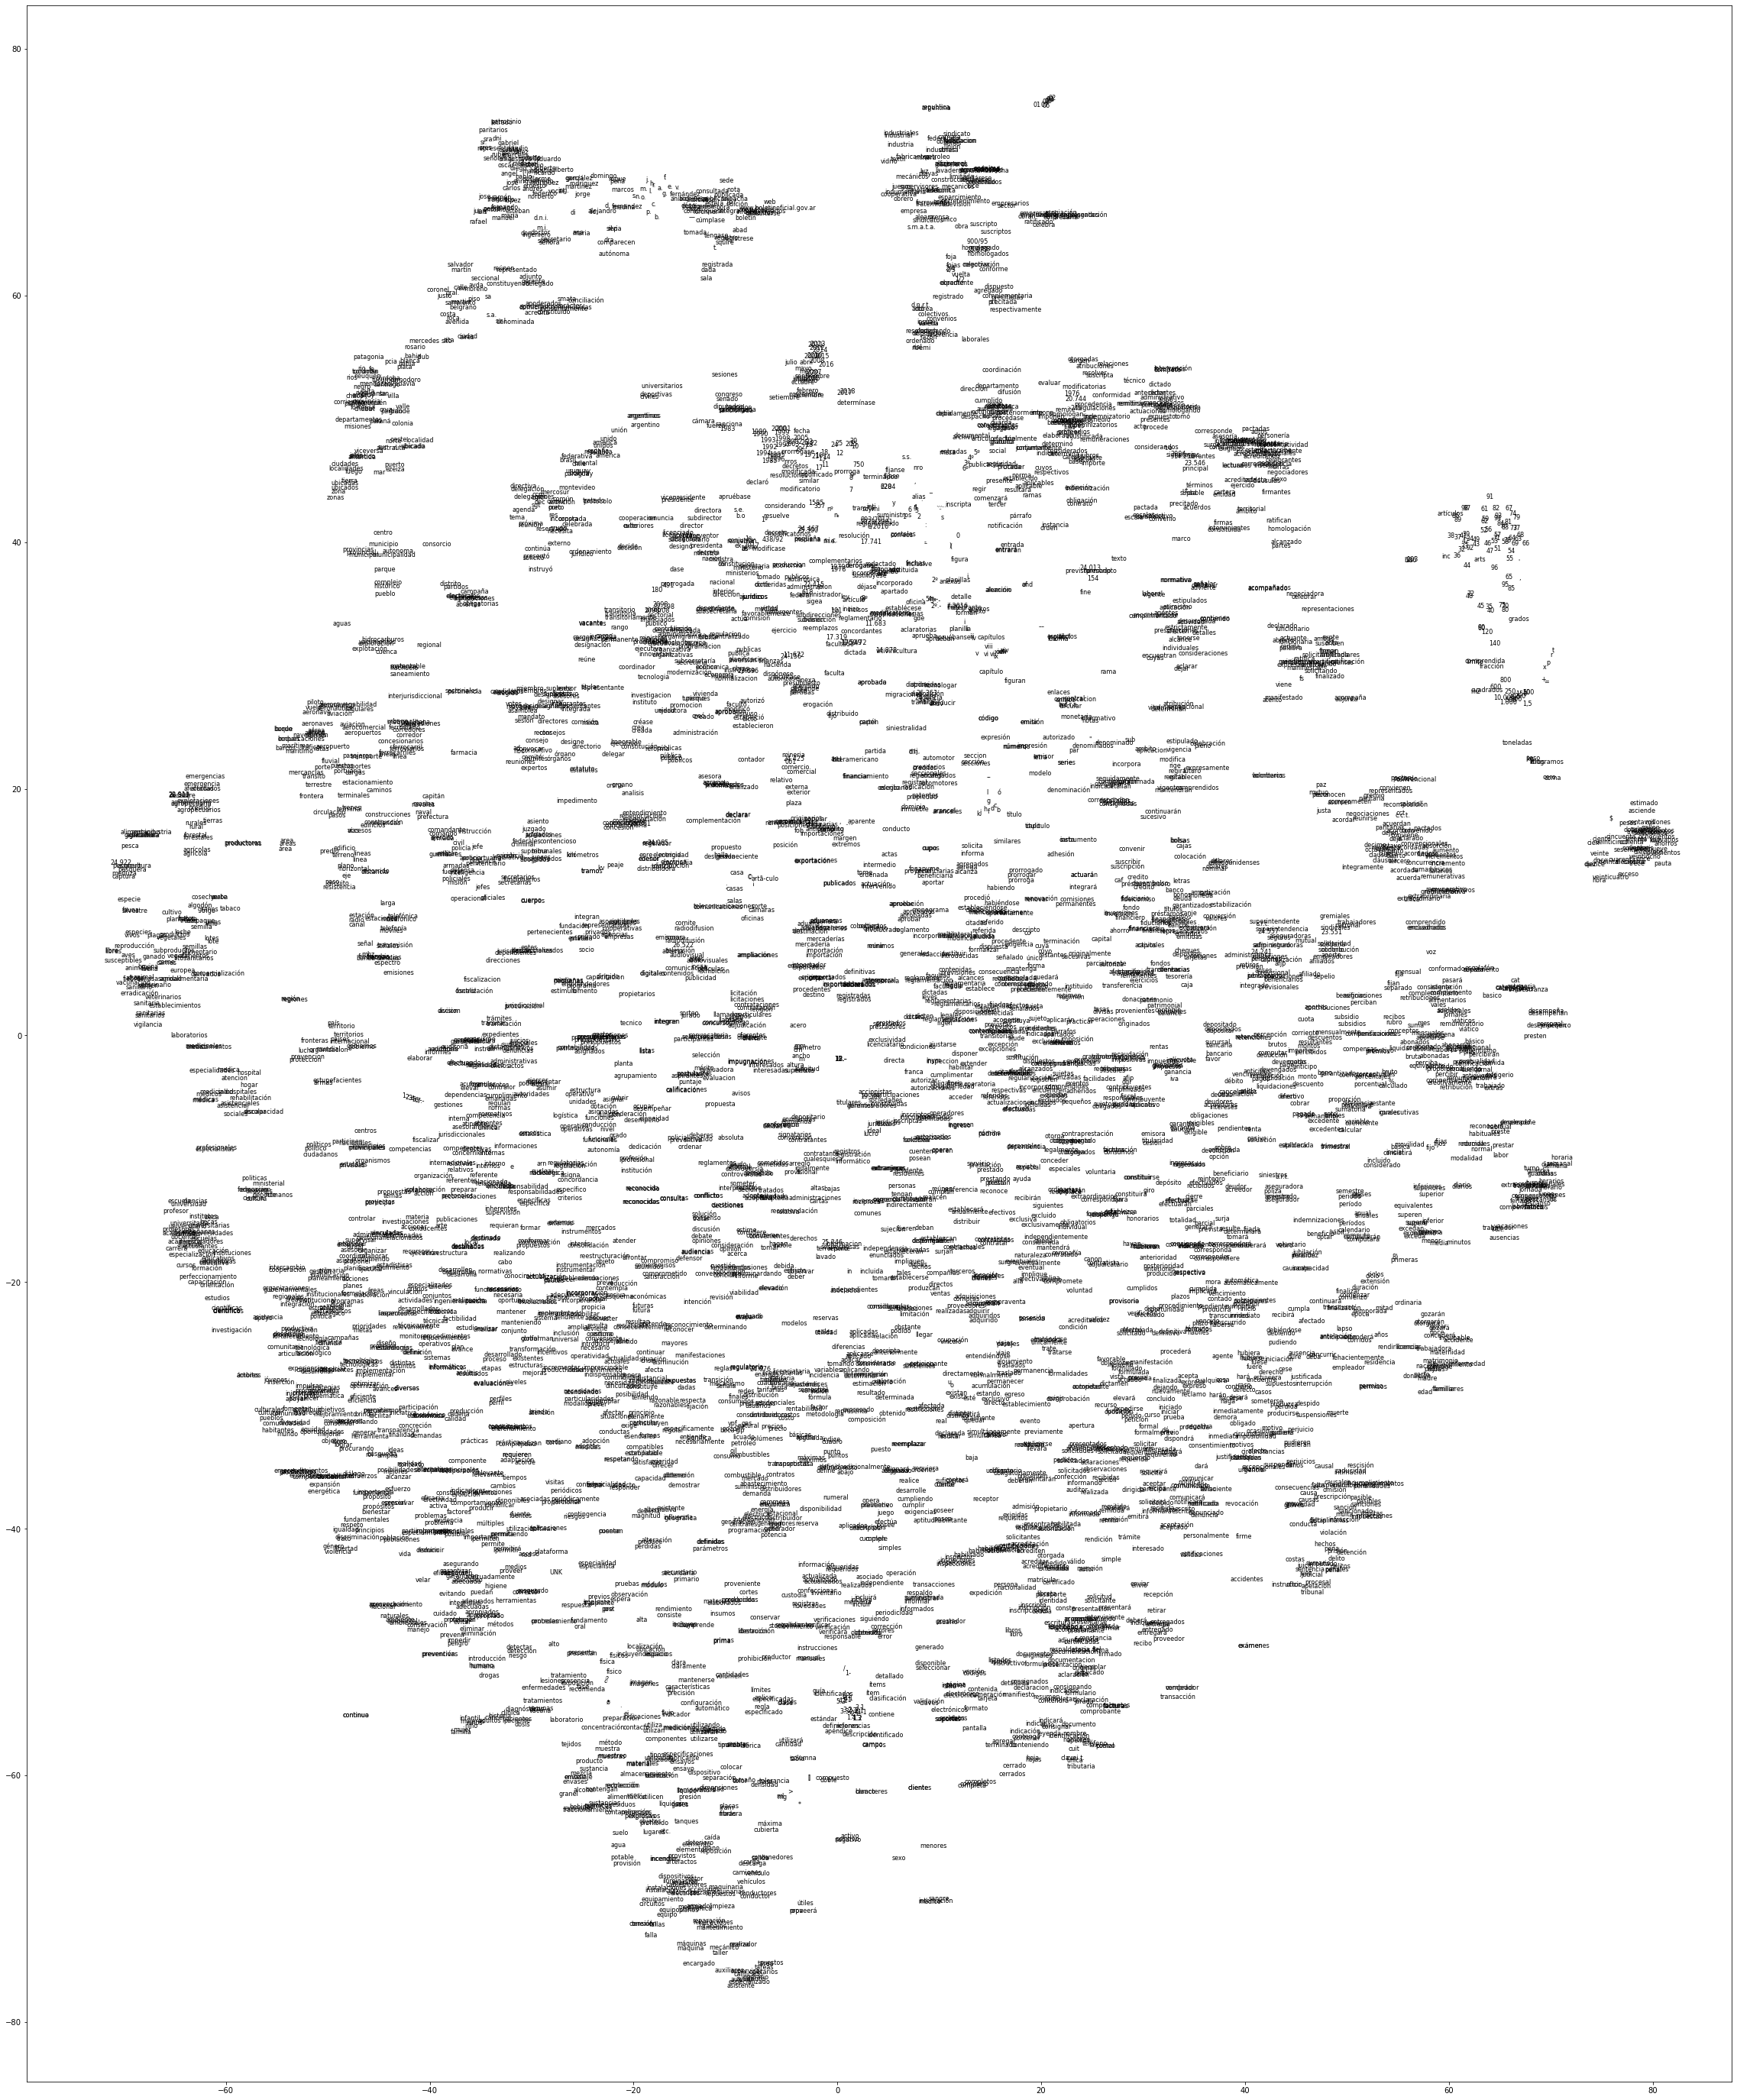

In [37]:
vsm.tsne_viz(infoleg20_ppmi)

## Referencias

- Bojanowski, P., Grave, E., Joulin, A., & Mikolov, T. (2017). Enriching word vectors with subword information. Transactions of the Association for Computational Linguistics, 5, 135-146.
- Deerwester, S., Dumais, S. T., Furnas, G. W., Landauer, T. K., & Harshman, R. (1990). Indexing by latent semantic analysis. Journal of the American society for information science, 41(6), 391-407.
- Firth, J. R. (1957). A synopsis of linguistic theory, 1930-1955. Studies in linguistic analysis.
- Harris, Z. S. (1954). Distributional structure. Word, 10(2-3), 146-162.
- Maaten, L. V. D., & Hinton, G. (2008). Visualizing data using t-SNE. Journal of machine learning research, 9(Nov), 2579-2605.
- Schütze, H. (1993). Word space. In Advances in neural information processing systems (pp. 895-902).
- Turney, P. D., & Pantel, P. (2010). From frequency to meaning: Vector space models of semantics. Journal of artificial intelligence research, 37, 141-188.
- Wittgenstein, L. (1953). Philosophical investigations. (Translated by GE Anscombe) Oxford: Blackwell.
- Zipf, G. K. (1949). Human behavior and the principle of least effort.